
Тест метода: Метод дихотомии
Метод bisection_method:
Критические точки: [-0.9999956403459824]
Значения второй производной: [0.2706776467150952]
Функция унимодальна (имеет единственный экстремум).
Время выполнения: 17 milliseconds

Тест метода: Метод золотого сечения
Метод golden_section_method:
Критические точки: [-1.0000018036151677]
Значения второй производной: [0.27066763737055655]
Функция унимодальна (имеет единственный экстремум).
Время выполнения: 24 milliseconds

Тест метода: Метод Фибоначчи
Метод fibonacci_method:
Критические точки: [-0.9999934744590331]
Значения второй производной: [0.27068116424275745]
Функция унимодальна (имеет единственный экстремум).
Время выполнения: 34 milliseconds

Сравнение методов по времени выполнения:
bisection_method: 17 milliseconds
golden_section_method: 24 milliseconds
fibonacci_method: 34 milliseconds


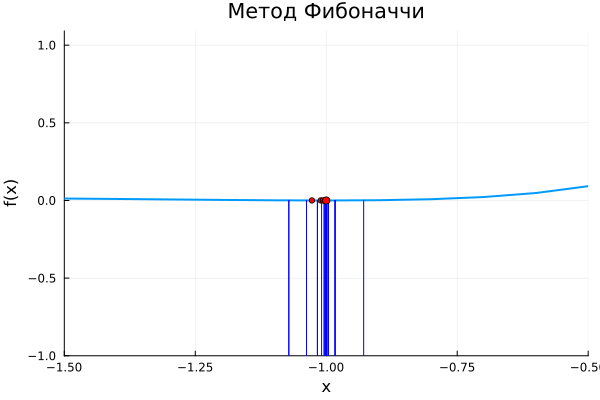

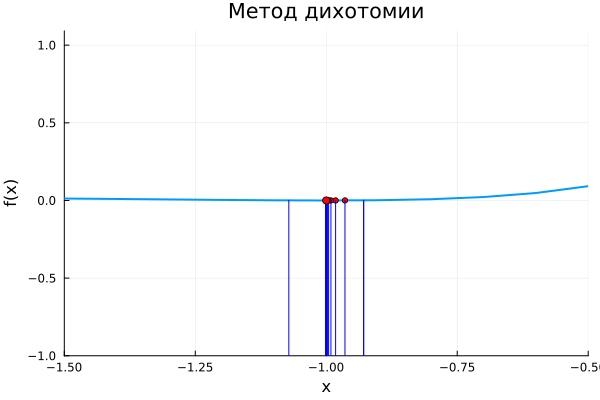

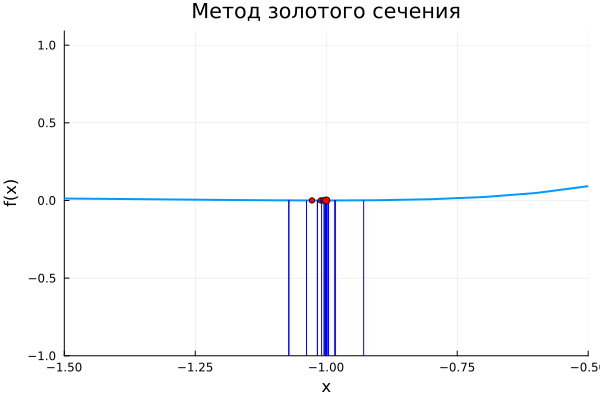

In [42]:
using Printf
using Random
using Dates
using Plots

function f(x)
    return (x+1)^2 * exp(2*x);
end

function df(x)
    return 6 * x * exp(2*x) + 4*exp(2*x) + 2 * x^2 * exp(2*x)
end

function d2f(x)
    return 14 * exp(2*x) + 16 * x * exp(2*x) + 4 * x^2 * exp(2*x)
end

function bisection_method(f, a, b)
    if f(a) * f(b) > 0
        return nothing, []
    end
    steps = []
    while abs(b - a) > 1e-5
        c = (a + b) / 2
        push!(steps, (a, b))
        if f(c) == 0
            return c, steps
        elseif f(a) * f(c) < 0
            b = c
        else
            a = c
        end
    end
    return (a + b) / 2, steps
end

function golden_section_method(f, a, b)
    if f(a) * f(b) > 0
        return nothing, []
    end

    φ = (1 + sqrt(5)) / 2
    steps = []
    
    x1 = b - (b - a) / φ
    x2 = a + (b - a) / φ
    
    while abs(b - a) > 1e-5
        push!(steps, (a, b))
        
        if abs(f(x1)) < abs(f(x2))
            b = x2
        else
            a = x1
        end
        
        x1 = b - (b - a) / φ
        x2 = a + (b - a) / φ
    end
    
    return (a + b) / 2, steps
end

function fibonacci_method(f, a, b, n=20)
    if f(a) * f(b) > 0
        return nothing, []
    end

    fib = [1, 1]
    for i in 3:n+1
        push!(fib, fib[end] + fib[end-1])
    end

    steps = []
    
    x1 = a + (b - a) * fib[n-1] / fib[n+1]
    x2 = a + (b - a) * fib[n] / fib[n+1]
    
    for k in 1:n-1
        push!(steps, (a, b))
        
        if abs(f(x1)) < abs(f(x2))
            b = x2
        else
            a = x1
        end
        
        if n-k-1 > 0
            x1 = a + (b - a) * fib[n-k-1] / fib[n-k+1]
            x2 = a + (b - a) * fib[n-k] / fib[n-k+1]
        end
    end
    
    return (a + b) / 2, steps
end

function find_critical_points(method, a, b, n)
    critical_points = []
    x = a
    while x < b
        x_next = x + (b - a) / n
        if x_next > b
            break
        end
        root, steps = method(df, x, x_next)
        if root !== nothing
            push!(critical_points, (root, steps))
        end
        x = x_next
    end
    return critical_points
end

function check_unimodality(method, a, b, n)
    t_start = now()
    crit_points = find_critical_points(method, a, b, n)
    elapsed_time = now() - t_start

    if isempty(crit_points)
        println("Метод $(method): нет критических точек, функция монотонна ⇒ унимодальна.")
        return true, elapsed_time, crit_points
    end

    second_derivatives = [d2f(c[1]) for c in crit_points]

    println("Метод $(method):")
    println("Критические точки: ", [c[1] for c in crit_points])
    println("Значения второй производной: ", second_derivatives)

    if all(d -> d > 0, second_derivatives) || all(d -> d < 0, second_derivatives)
        println("Функция унимодальна (имеет единственный экстремум).")
        return true, elapsed_time, crit_points
    else
        println("Функция не унимодальна (есть и минимум, и максимум).")
        return false, elapsed_time, crit_points
    end
end

function plot_method(f, a, b, method_name, crit_points)
    x = a:0.1:b
    y = f.(x)
    
    p = plot(x, y, label="f(x)", xlabel="x", ylabel="f(x)", title="$method_name", linewidth=2, legend=false)

    ymin = minimum(y) - 1

    plot!(p, xlims=(a, b), ylims=(ymin, maximum(y) + 1))
    hline!(y=0, linestyle=:solid, linewidth=1)
    vline!(x=0, linestyle=:solid, linewidth=1)

    for (root, steps) in crit_points
        for step in steps
            plot!(p, [step[1], step[1]], [ymin, f(step[1])], color=:blue, linewidth=1, label="")
            plot!(p, [step[2], step[2]], [ymin, f(step[2])], color=:blue, linewidth=1, label="")
            midpoint = (step[1] + step[2]) / 2
            scatter!(p, [midpoint], [f(midpoint)], color=:red, markersize=3)
        end
        scatter!(p, [root], [f(root)], color=:red, label="Точка экстремума", markersize=4)
    end
    
    display(p)
end

methods = [bisection_method, golden_section_method, fibonacci_method]
method_names = ["Метод дихотомии", "Метод золотого сечения", "Метод Фибоначчи"]
a = -1.5
b = -0.5
results = Dict()

all_critical_points = Dict()

for (method, method_name) in zip(methods, method_names)
    println("\n==============================")
    println("Тест метода: ", method_name)
    unimodal, time_taken, crit_points = check_unimodality(method, a, b, 7)
    all_critical_points[method_name] = crit_points
    results[method] = time_taken
    println("Время выполнения: ", time_taken)
end

println("\n==============================")
println("Сравнение методов по времени выполнения:")
for (method, time) in results
    @printf "%s: %s\n" method time
end

for (method_name, crit_points) in all_critical_points
    plot_method(f, a, b, method_name, crit_points)
end